In [1]:
import random
import numpy as np
import torch

from neuralee.embedding import NeuralEE
from neuralee.dataset import PbmcDataset 
from neuralee._aux import scatter

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [2]:
pbmc_dataset = PbmcDataset(save_path='data/')
pbmc_dataset.log_shift()
pbmc_dataset.subsample_genes(500)  
pbmc_dataset.standardscale()

File ../data/gene_info_pbmc.csv already downloaded
File ../data/pbmc_metadata.pickle already downloaded
File ../data/10X/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
File ../data/10X/pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Keeping 33694 genes
Downsampling from 12721 to 11990 cells
Downsampling from 33694 to 3346 genes
Downsampling from 3346 to 500 genes


Compute affinity, perplexity=20.0, on entire dataset
Elastic Embedding, lambda=1, completed in 17.37s, EE loss is 0.265516
Elastic Embedding, lambda=10, completed in 14.90s, EE loss is 1.120025
Compute affinity, perplexity=20.0, N_small=11990, on each batch
Neural Elastic Embedding, lambda=1, completed in 24.24s, EE loss is 0.268011
Neural Elastic Embedding, lambda=10, completed in 24.23s, EE loss is 1.125335
Compute affinity, perplexity=20.0, N_small=5995, on each batch
Neural Elastic Embedding, lambda=1, completed in 14.42s, EE loss is 0.277938
Neural Elastic Embedding, lambda=10, completed in 14.40s, EE loss is 1.149334
Compute affinity, perplexity=20.0, N_small=2997, on each batch
Neural Elastic Embedding, lambda=1, completed in 12.52s, EE loss is 0.281804
Neural Elastic Embedding, lambda=10, completed in 12.97s, EE loss is 1.183489


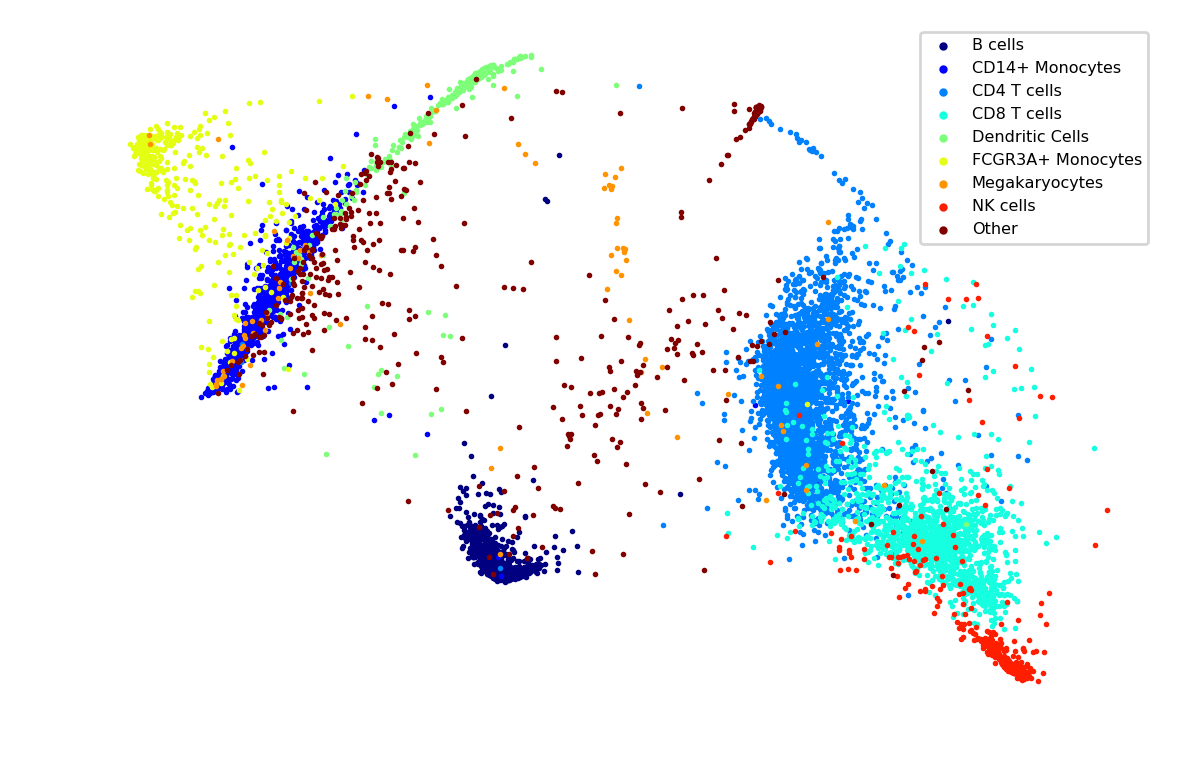

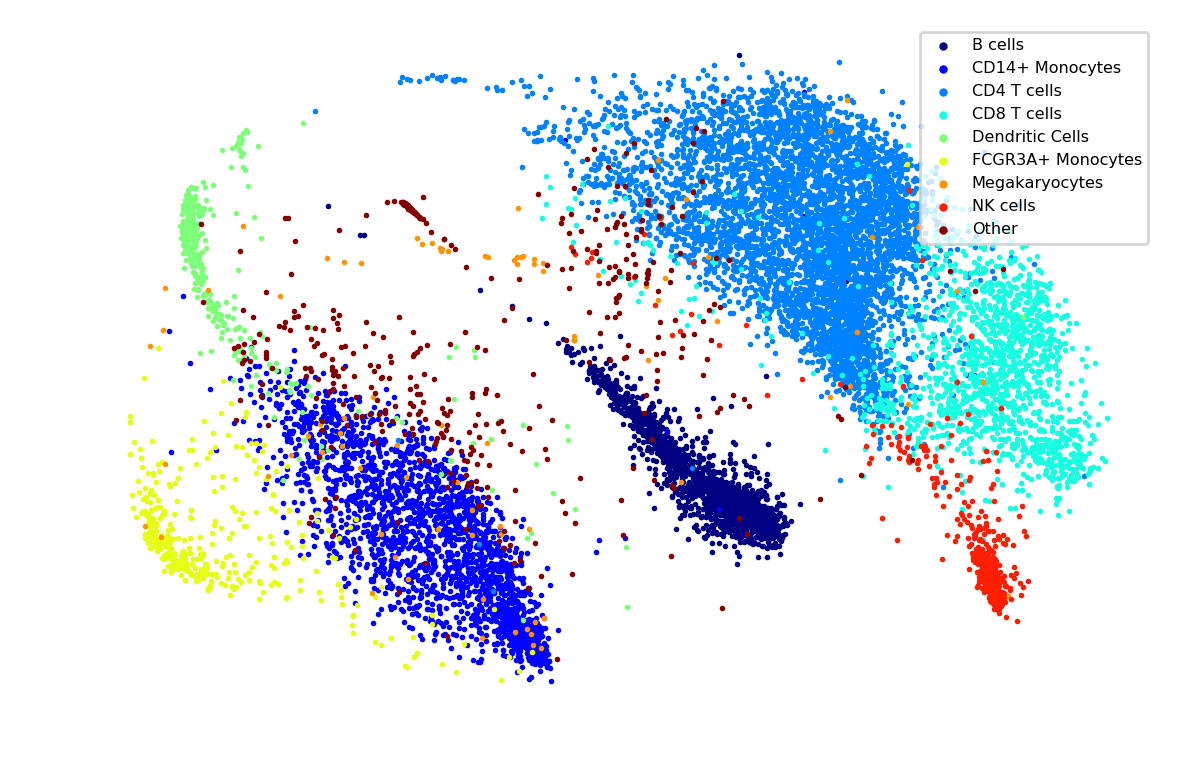

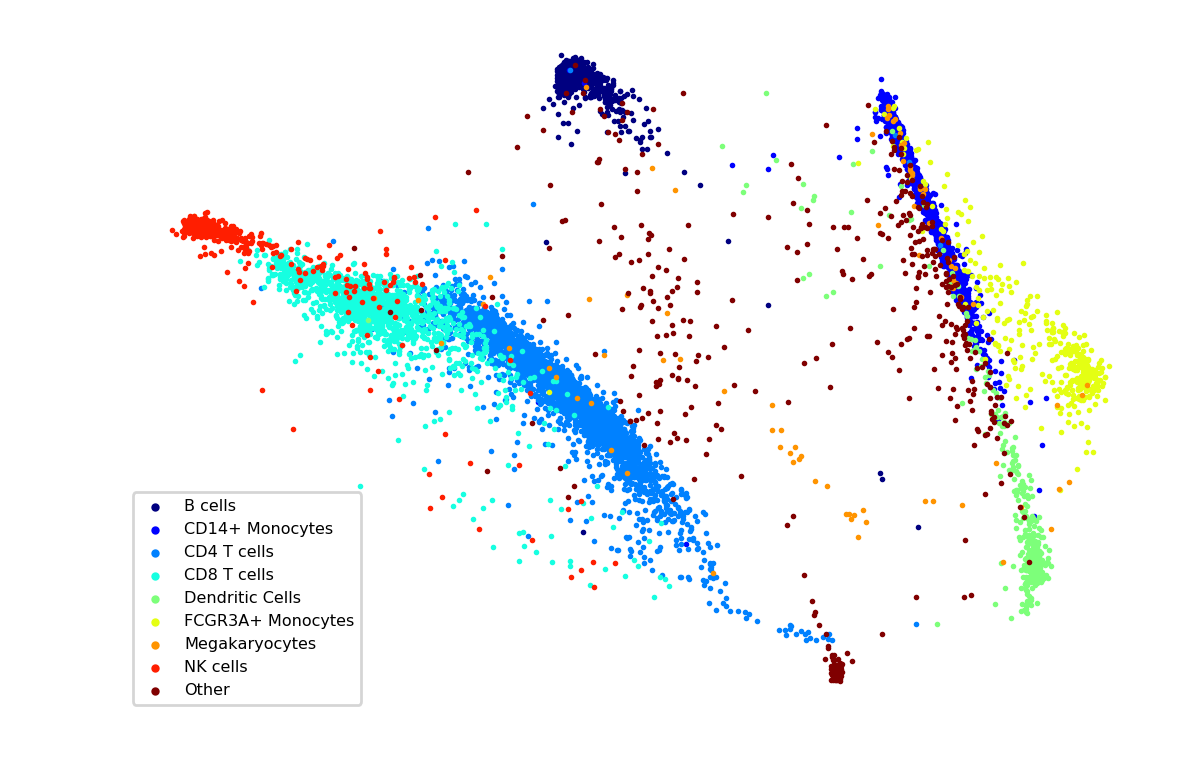

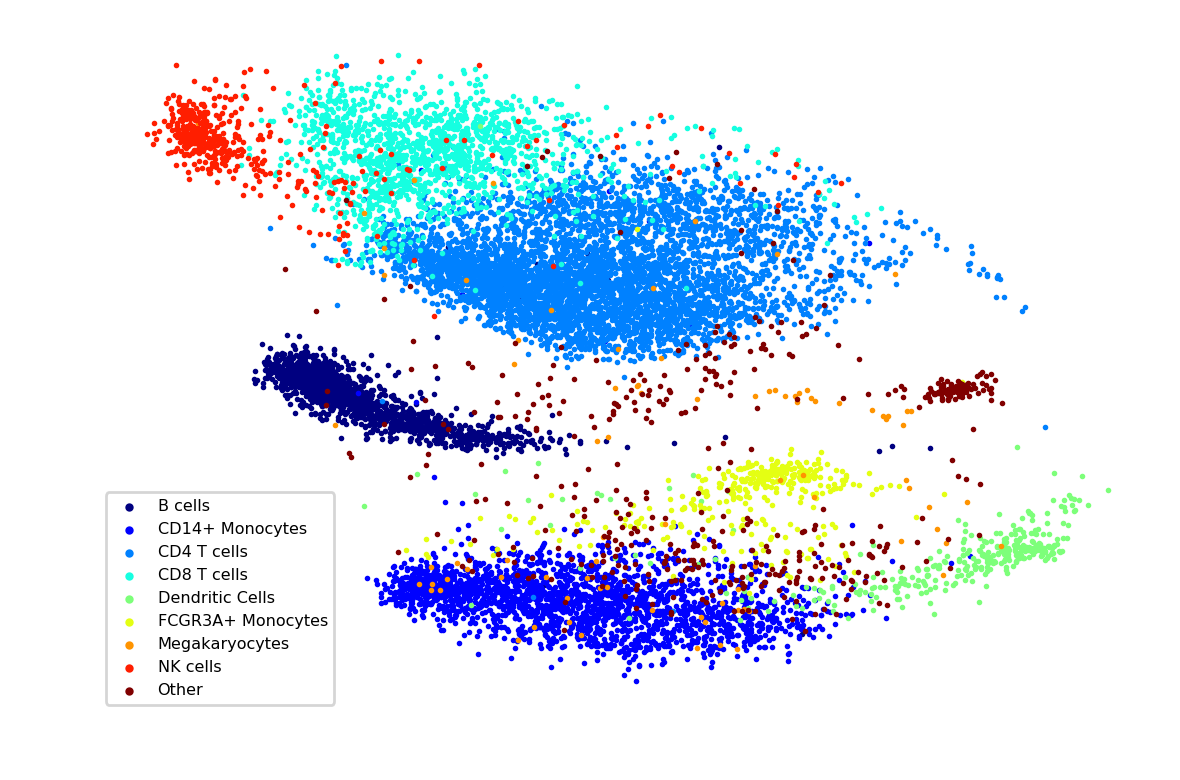

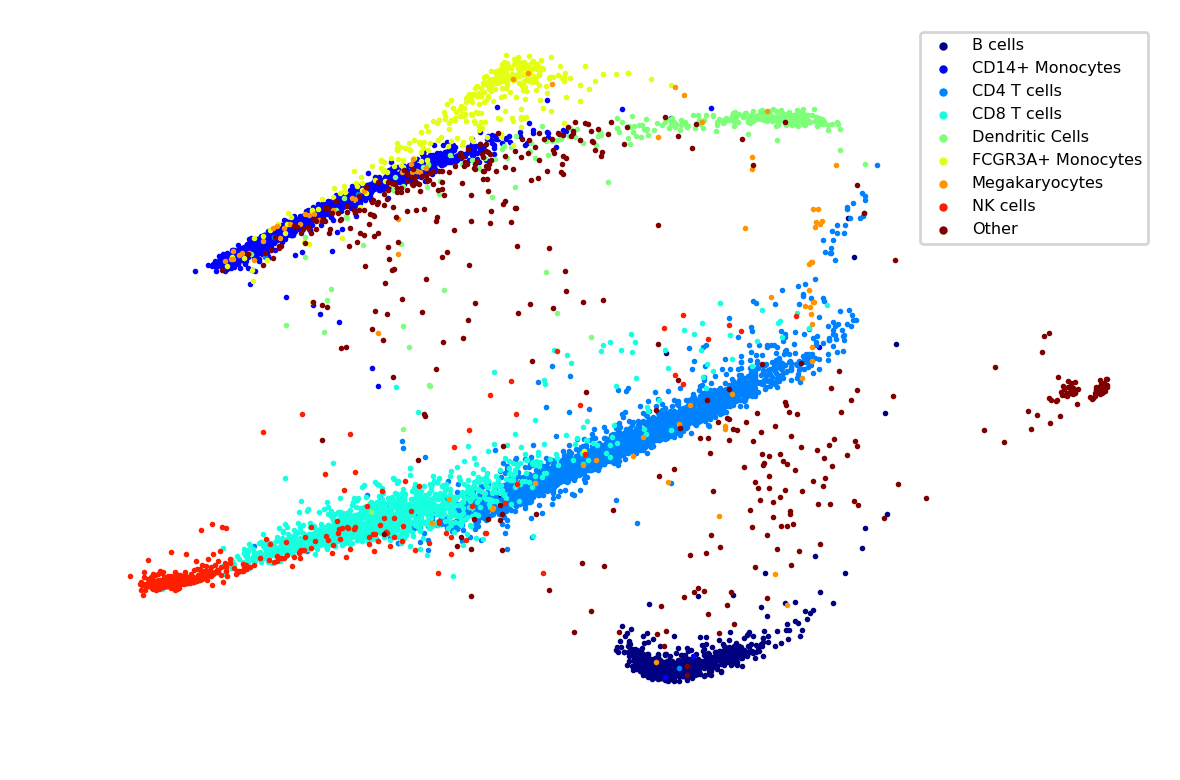

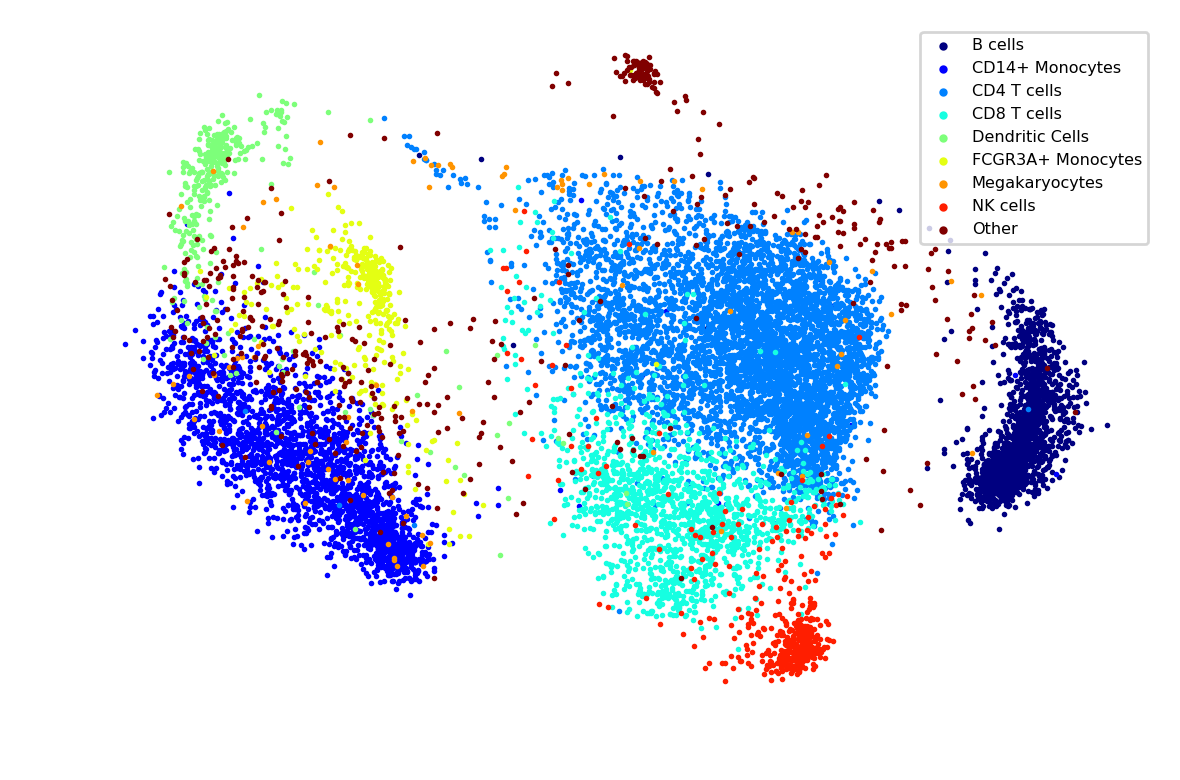

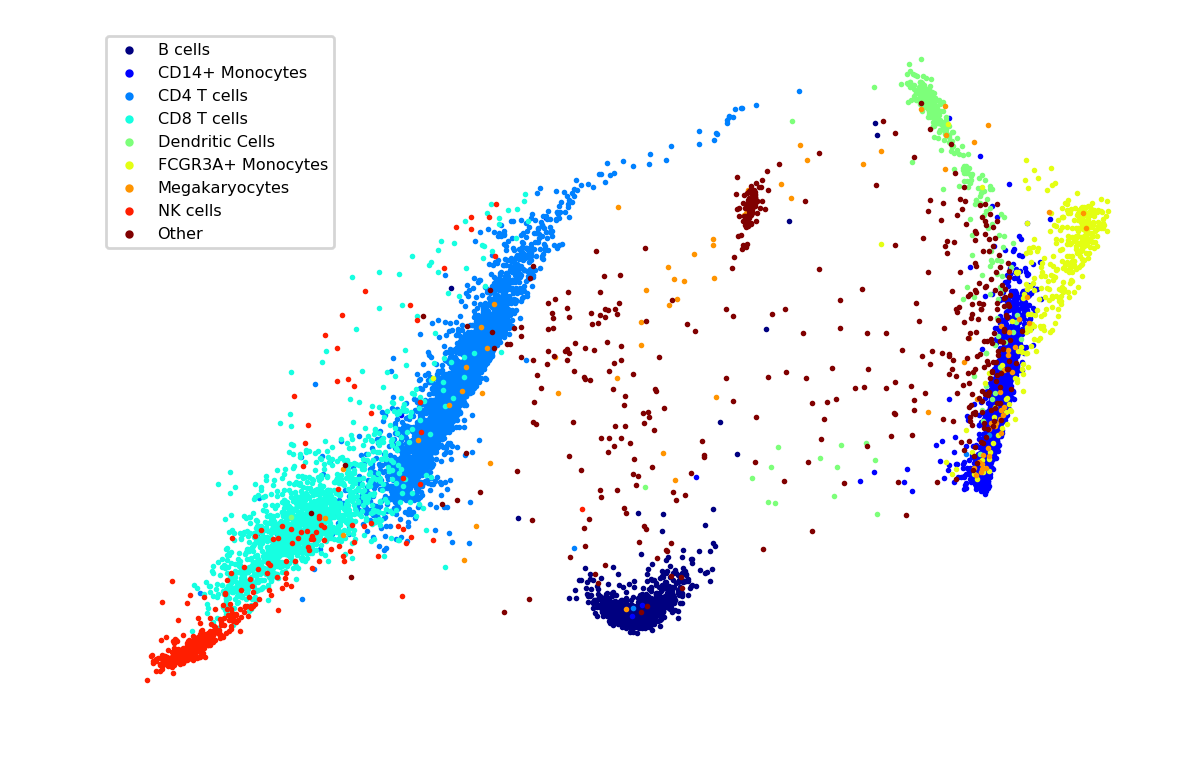

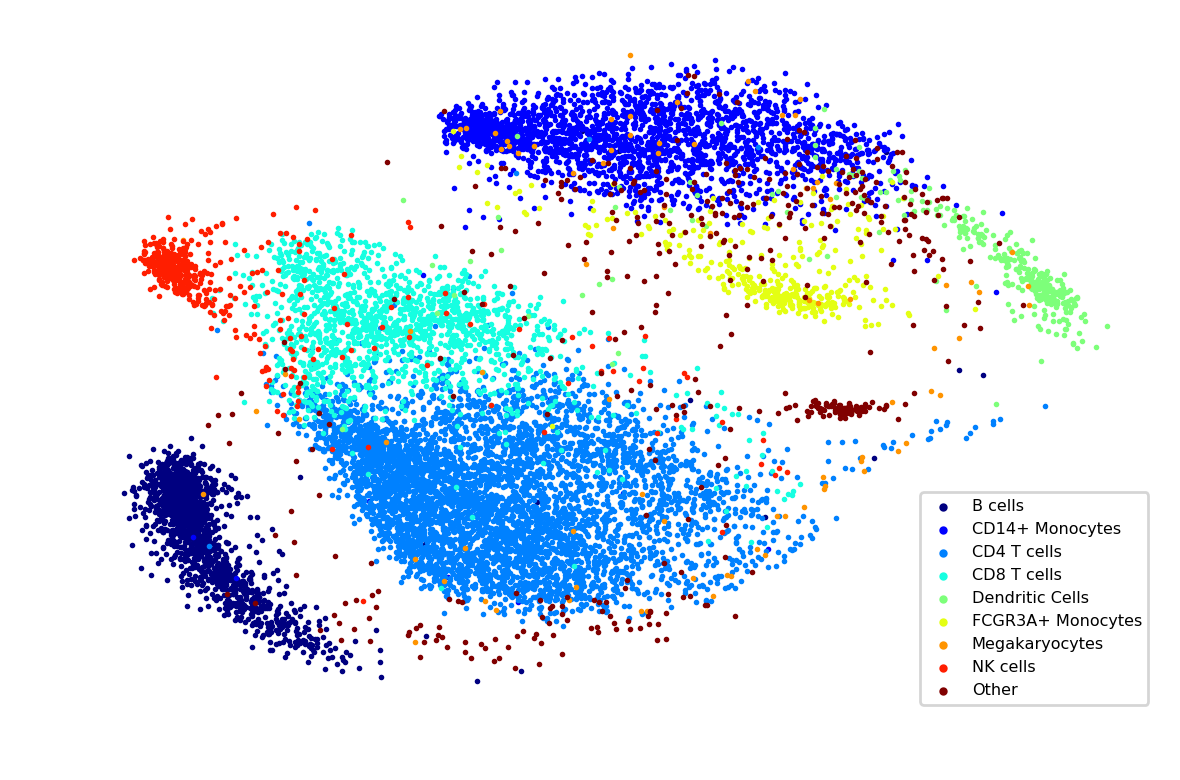

In [3]:
N_smalls = [1.0, 0.5, 0.25]
lams = [1, 10]

pbmc_dataset.affinity()
for lam in lams:
    NEE = NeuralEE(pbmc_dataset, lam=lam, device=device)
    results = NEE.EE() 
    scatter(results['X'].numpy(), NEE.labels, 
            pbmc_dataset.cell_types)

for N_small in N_smalls:
    pbmc_dataset.affinity_split(N_small=N_small)
    for lam in lams:
        NEE = NeuralEE(pbmc_dataset, lam=lam, device=device)
        results_Neural = NEE.fine_tune()
        scatter(results_Neural['X'].numpy(), NEE.labels, 
                pbmc_dataset.cell_types)